In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
from statistics import mode

# **Import data**

In [2]:
df = pd.read_csv("data/online_retail_II.csv")
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,01/12/2009 07:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,01/12/2009 07:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,01/12/2009 07:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,01/12/2009 07:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,01/12/2009 07:45,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,09/12/2010 20:01,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,09/12/2010 20:01,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,09/12/2010 20:01,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,09/12/2010 20:01,3.75,17530.0,United Kingdom


In [3]:
# Check preliminary info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      525461 non-null  object 
 1   StockCode    525461 non-null  object 
 2   Description  522533 non-null  object 
 3   Quantity     525461 non-null  int64  
 4   InvoiceDate  525461 non-null  object 
 5   Price        525461 non-null  float64
 6   Customer ID  417534 non-null  float64
 7   Country      525461 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.1+ MB


In [4]:
n_original_rows = df.shape[0]   # this will be used later on

# **Data cleaning**

- ## Fixing dtypes

Column `InvoiceDate` should be in datetime format.

In [5]:
df = df.astype({'InvoiceDate': 'datetime64'})

- ## Filtering prices and quantities

Only entries with prices greater than 0 ***and*** quantities greater than 0 should be kept:

In [6]:
df = df.query("(Price > 0) & (Quantity > 0)")
rows_after = df.shape[0]   # number of rows after removing invalid prices/quantities

print(f"Total number of rows in the imported dataset (original): {n_original_rows}\n\
Number of rows after dropping: {rows_after}\n\
% of data removed: {100*(1-rows_after/n_original_rows):.2f}")

Total number of rows in the imported dataset (original): 525461
Number of rows after dropping: 511566
% of data removed: 2.64


- ## Fixing NA's 

In [7]:
# Check NA's in each column
df.isna().sum()

Invoice             0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
Price               0
Customer ID    103902
Country             0
dtype: int64

In [8]:
# Checking NA's from 'Customer ID'
df[df['Customer ID'].isna()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-01-12 11:49:00,0.55,NaN,United Kingdom
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-01-12 11:49:00,0.85,NaN,United Kingdom
1055,489548,22271,FELTCRAFT DOLL ROSIE,1,2009-01-12 12:32:00,2.95,NaN,United Kingdom
1056,489548,22254,FELT TOADSTOOL LARGE,12,2009-01-12 12:32:00,1.25,NaN,United Kingdom
1057,489548,22273,FELTCRAFT DOLL MOLLY,3,2009-01-12 12:32:00,2.95,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
525143,538154,82599,FANNY'S REST STOPMETAL SIGN,1,2010-09-12 16:35:00,4.21,NaN,United Kingdom
525144,538154,84029E,RED WOOLLY HOTTIE WHITE HEART.,5,2010-09-12 16:35:00,8.47,NaN,United Kingdom
525145,538154,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,4,2010-09-12 16:35:00,8.47,NaN,United Kingdom
525146,538154,85099B,JUMBO BAG RED RETROSPOT,1,2010-09-12 16:35:00,4.21,NaN,United Kingdom


Apparently, these entries are valid. Let's keep them for now.

# **Data integrity**
#### (and maybe more cleaning!)

- ## Checking the `Invoice` column

Is it really an object-dtype column? Let's see which entries are not full numbers.

In [9]:
df[df.Invoice.str.contains("\D")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
76799,C496350,M,Manual,1,2010-01-02 08:24:00,373.57,NaN,United Kingdom


Only one entry (out of 511k+) is not a full-number invoice. Let's drop it and pretend nothing ever happened, 'kay? Let's also change the dtype of `Invoice` to `int`.

In [10]:
df = df.drop(76799).astype({"Invoice": "int32"})

What about the number of characters in each value of `Invoice`? Let's see...

In [11]:
df.Invoice.apply(lambda x: len(str(x))).value_counts()

6    511565
Name: Invoice, dtype: int64

Yay for consistency! No further steps are needed for this column (at least that's what we hope so).

- ## Checking the `StockCode` column

Let's take a look at the top-5 and bottom-5 values.

In [12]:
df.StockCode.value_counts()

85123A    3421
22423     2044
85099B    2012
21212     1920
21232     1713
          ... 
35999        1
84509e       1
85132c       1
47590a       1
21120        1
Name: StockCode, Length: 4251, dtype: int64

Right, so it's common to have letters and numbers as values. What about their lengths?

In [13]:
df['StockCode'].str.len().value_counts()

5     434882
6      73434
7        887
4        773
3        730
1        565
2        131
8         80
12        69
9         14
Name: StockCode, dtype: int64

Hmm, how would that look in a histogram?

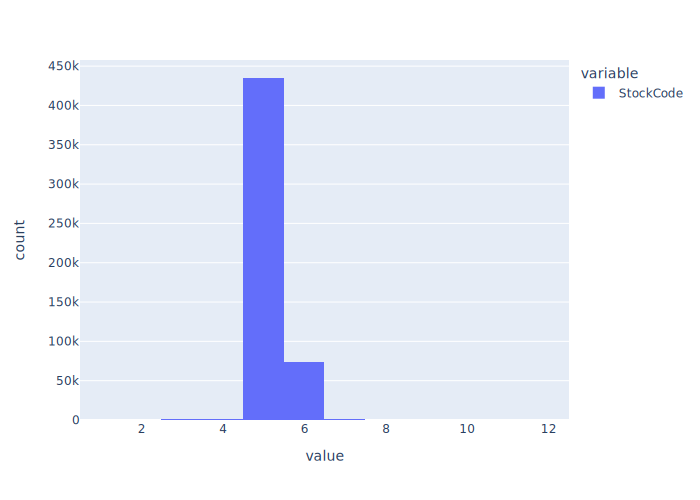

In [14]:
aux = df['StockCode'].str.len()   # series containing the length of each value of 'StockCode'

fig = px.histogram(aux)
fig.show('svg')

Basically, anything not having 5 or 6 characters could potentially be an invalid StockCode (let's take that for granted, shall we?). We can't manually check every single value, but we can take a quick look over all the other non-5-non-6 values. Let's do it in batches, starting with values with length = 1, and then 2, etc.

# BUT,

before we continue, let's create an empty list named `removals`.

In this list we're gonna save all values that can be safely removed from the dataframe. Then, after all values of `StockCode` are checked *(really?)*, we can remove all these values at once. 

**"Why?"**, you may ask.

Right.

So... In order to keep using `aux` without warnings popping-up on the screen, we ought to keep the indexes of both the dataframe (`df`) and the series (`aux`) as it is, since they're matching perfectly (`aux` was created from an exact part (a column) of `df`). Removing values in between batches would cause the indexes to become misaligned.

In [15]:
removals = []

In [16]:
# Checking values with len = 1
df[aux == 1]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
2697,489609,M,Manual,1,2009-01-12 14:50:00,4.00,NaN,United Kingdom
11310,490300,M,Manual,1,2009-04-12 14:19:00,0.85,12970.0,United Kingdom
11311,490300,M,Manual,1,2009-04-12 14:19:00,0.21,12970.0,United Kingdom
17386,490760,M,Manual,1,2009-08-12 09:49:00,10.00,14295.0,United Kingdom
17887,490881,M,Manual,1,2009-08-12 12:58:00,10.00,16210.0,United Kingdom
...,...,...,...,...,...,...,...,...
517330,537534,M,Manual,1,2010-07-12 11:48:00,924.59,NaN,United Kingdom
521074,537800,M,Manual,12,2010-08-12 13:08:00,0.19,12748.0,United Kingdom
521122,537804,M,Manual,12,2010-08-12 13:17:00,2.95,12748.0,United Kingdom
521124,537804,M,Manual,12,2010-08-12 13:17:00,0.19,12748.0,United Kingdom


In [17]:
df[aux == 1]['StockCode'].value_counts()

M    555
D      5
m      4
S      1
Name: StockCode, dtype: int64

Hmm, multiple values. All `M` values seem to be associated with a `Manual` item. Let's make sure this is true.

In [18]:
df.query('StockCode == "M"')['Description'].value_counts()

Manual    555
Name: Description, dtype: int64

It is. Since these are not valid items, to the trash they go!

Let's check those `D`, `m` and `S` values all at once.

In [19]:
df[df.StockCode.apply(lambda x: x in['D', 'm', 'S'])]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
96608,498492,m,Manual,1,2010-02-19 10:56:00,2.55,NaN,United Kingdom
96609,498492,m,Manual,1,2010-02-19 10:56:00,3.40,NaN,United Kingdom
157226,504396,m,Manual,1,2010-04-13 11:45:00,4.00,NaN,United Kingdom
160443,504700,D,Discount,1,2010-04-15 18:08:00,57.63,17032.0,United Kingdom
181508,506601,S,SAMPLES,1,2010-04-30 14:49:00,73.80,NaN,United Kingdom
212633,509979,D,Discount,1,2010-05-26 14:07:00,101.99,12843.0,United Kingdom
228780,511509,m,Manual,1,2010-08-06 15:26:00,2.55,NaN,United Kingdom
312285,519808,D,Discount,192,2010-08-20 12:50:00,1.00,16422.0,United Kingdom
494226,535657,D,Discount,1,2010-11-28 11:20:00,13.98,14527.0,United Kingdom
501237,536158,D,Discount,1,2010-11-30 11:57:00,32.29,13634.0,United Kingdom


These are also trash. We can safely remove all values of `StockCode` with length = 1. Let's add them to our `removals` list.

In [20]:
removals += ['D', 'm', 'S', 'M']

In [21]:
# Checking values with len = 2
df[aux == 2]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
9292,490127,C2,CARRIAGE,1,2009-03-12 18:13:00,50.0,14156.0,EIRE
14481,490541,C2,CARRIAGE,1,2009-07-12 09:25:00,50.0,NaN,EIRE
14502,490542,C2,CARRIAGE,1,2009-07-12 09:42:00,50.0,14911.0,EIRE
19541,490998,C2,CARRIAGE,1,2009-08-12 17:24:00,50.0,16253.0,United Kingdom
22803,491160,C2,CARRIAGE,1,2009-10-12 10:29:00,50.0,14911.0,EIRE
...,...,...,...,...,...,...,...,...
504361,536540,C2,CARRIAGE,1,2010-01-12 14:05:00,50.0,14911.0,EIRE
515057,537368,C2,CARRIAGE,1,2010-06-12 12:40:00,50.0,14911.0,EIRE
515390,537378,C2,CARRIAGE,1,2010-06-12 13:06:00,50.0,14911.0,EIRE
522913,537963,C2,CARRIAGE,1,2010-09-12 11:30:00,50.0,13369.0,United Kingdom


In [22]:
df[aux == 2].StockCode.value_counts()

C2    131
Name: StockCode, dtype: int64

C2? Carriage? Trash!

In [23]:
removals.append('C2')

In [24]:
# Checking values with len = 3
df[aux == 3]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
2379,489597,DOT,DOTCOM POSTAGE,1,2009-01-12 14:28:00,647.19,NaN,United Kingdom
2539,489600,DOT,DOTCOM POSTAGE,1,2009-01-12 14:43:00,55.96,NaN,United Kingdom
2551,489601,DOT,DOTCOM POSTAGE,1,2009-01-12 14:44:00,68.39,NaN,United Kingdom
2571,489602,DOT,DOTCOM POSTAGE,1,2009-01-12 14:45:00,59.35,NaN,United Kingdom
2619,489603,DOT,DOTCOM POSTAGE,1,2009-01-12 14:46:00,42.39,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
524272,538071,DOT,DOTCOM POSTAGE,1,2010-09-12 14:09:00,885.94,NaN,United Kingdom
524887,538148,DOT,DOTCOM POSTAGE,1,2010-09-12 16:26:00,547.32,NaN,United Kingdom
525000,538149,DOT,DOTCOM POSTAGE,1,2010-09-12 16:27:00,620.68,NaN,United Kingdom
525126,538153,DOT,DOTCOM POSTAGE,1,2010-09-12 16:31:00,822.94,NaN,United Kingdom


In [25]:
df[aux == 3].StockCode.value_counts()

DOT    730
Name: StockCode, dtype: int64

Apparently, all length = 3 values are not items by themselves. `DOT` should be added to our list.

In [26]:
removals.append('DOT')

In [27]:
# Checking values with len = 4
df[aux == 4]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
89,489439,POST,POSTAGE,3,2009-01-12 09:28:00,18.0,12682.0,France
126,489444,POST,POSTAGE,1,2009-01-12 09:55:00,141.0,12636.0,USA
173,489447,POST,POSTAGE,1,2009-01-12 10:10:00,130.0,12362.0,Belgium
625,489526,POST,POSTAGE,6,2009-01-12 11:50:00,18.0,12533.0,Germany
1244,489557,POST,POSTAGE,4,2009-01-12 12:52:00,18.0,12490.0,France
...,...,...,...,...,...,...,...,...
522916,537967,POST,POSTAGE,1,2010-09-12 11:31:00,18.0,12494.0,France
522930,537995,POST,POSTAGE,2,2010-09-12 11:39:00,18.0,12712.0,Germany
522974,538003,POST,POSTAGE,8,2010-09-12 12:05:00,18.0,12429.0,Denmark
523064,538008,POST,POSTAGE,5,2010-09-12 12:17:00,18.0,12683.0,France


In [28]:
df[aux == 4].StockCode.value_counts()

POST    759
PADS     14
Name: StockCode, dtype: int64

In [29]:
df.query('StockCode == "PADS"')

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
62299,494914,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-01-19 17:04:00,0.001,16705.0,United Kingdom
74731,496222,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-01-29 13:53:00,0.001,13583.0,United Kingdom
77702,496473,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-01-02 15:38:00,0.001,17350.0,United Kingdom
79794,496643,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-03-02 11:58:00,0.001,13408.0,United Kingdom
90798,497935,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-15 10:47:00,0.001,13408.0,United Kingdom
97716,498562,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-21 12:03:00,0.001,15182.0,United Kingdom
101718,499056,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-24 13:46:00,0.001,13765.0,United Kingdom
104480,499399,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-26 13:26:00,0.001,14459.0,United Kingdom
123947,501176,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-03-15 11:00:00,0.001,14857.0,United Kingdom
156809,504332,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-12-04 16:30:00,0.001,12671.0,Germany


Both values are trash, really. You can keep them if you want, but I am not.

In [30]:
removals += ['PADS', 'POST']

In [31]:
# Checking values with len = 7
df[aux == 7]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
572,489522,79323LP,LIGHT PINK CHERRY LIGHTS,1,2009-01-12 11:45:00,6.75,15998.0,United Kingdom
613,489526,15056BL,EDWARDIAN PARASOL BLACK,6,2009-01-12 11:50:00,5.95,12533.0,Germany
2620,489604,15056bl,EDWARDIAN PARASOL BLACK,1,2009-01-12 14:47:00,13.00,NaN,United Kingdom
3142,489658,15056BL,EDWARDIAN PARASOL BLACK,12,2009-01-12 17:31:00,5.95,15485.0,United Kingdom
3158,489658,79323LP,LIGHT PINK CHERRY LIGHTS,6,2009-01-12 17:31:00,6.75,15485.0,United Kingdom
...,...,...,...,...,...,...,...,...
519063,537645,15056bl,EDWARDIAN PARASOL BLACK,2,2010-07-12 15:34:00,12.72,NaN,United Kingdom
520482,537769,15056BL,EDWARDIAN PARASOL BLACK,2,2010-08-12 12:17:00,5.95,15021.0,United Kingdom
524462,538093,15056BL,EDWARDIAN PARASOL BLACK,12,2010-09-12 14:49:00,5.95,12682.0,France
524777,538148,15056bl,EDWARDIAN PARASOL BLACK,3,2010-09-12 16:26:00,12.72,NaN,United Kingdom


In [32]:
df[aux == 7].StockCode.value_counts()

15056BL    589
79323LP    170
79323GR     83
15056bl     31
TEST001      9
ADJUST2      3
TEST002      1
47503J       1
Name: StockCode, dtype: int64

Ok, these lists are getting bigger... From a quick glance, we can assume that:
- `15056BL` and `15056bl` are probably the same item
- `TEST001` and `TEST002` are not valid items
- `ADJUST2` is not valid either
- `79323LP` and `79323GR` have the same numbers, but different letters (why is that?)
- `47503J ` is all by itself... Is it a rare item or just a glitch in the matrix? (hint: you can only see 6 of its characters out of 7)

The answers are down below, in the next few cells.

In [33]:
df.query("StockCode == '15056BL' | StockCode == '15056bl'").head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
613,489526,15056BL,EDWARDIAN PARASOL BLACK,6,2009-01-12 11:50:00,5.95,12533.0,Germany
2620,489604,15056bl,EDWARDIAN PARASOL BLACK,1,2009-01-12 14:47:00,13.00,NaN,United Kingdom
3142,489658,15056BL,EDWARDIAN PARASOL BLACK,12,2009-01-12 17:31:00,5.95,15485.0,United Kingdom
3290,489675,15056BL,EDWARDIAN PARASOL BLACK,240,2009-02-12 09:47:00,4.60,13777.0,United Kingdom
3923,489789,15056BL,EDWARDIAN PARASOL BLACK,3,2009-02-12 11:59:00,5.95,15833.0,United Kingdom


In [34]:
df.query("StockCode == '15056BL' | StockCode == '15056bl'")['Description'].value_counts()

EDWARDIAN PARASOL BLACK    620
Name: Description, dtype: int64

Yes, they are the same item. Yes, they are valid.

We should take a moment to fix this lowercase/uppercase problem we just had. By default, StockCodes are all uppercase, so let's turn all entries into uppercases.

In [35]:
df['StockCode'] = df['StockCode'].apply(str.upper)

In [36]:
df.query("StockCode == 'ADJUST2' | StockCode == 'TEST001'")

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
27994,491725,TEST001,This is a test product.,10,2009-12-14 08:34:00,4.50,12346.0,United Kingdom
28251,491742,TEST001,This is a test product.,5,2009-12-14 11:00:00,4.50,12346.0,United Kingdom
28254,491744,TEST001,This is a test product.,5,2009-12-14 11:02:00,4.50,12346.0,United Kingdom
39398,492718,TEST001,This is a test product.,5,2009-12-18 10:47:00,4.50,12346.0,United Kingdom
45228,493410,TEST001,This is a test product.,5,2010-04-01 09:24:00,4.50,12346.0,United Kingdom
45230,493412,TEST001,This is a test product.,5,2010-04-01 09:53:00,4.50,12346.0,United Kingdom
56117,494450,TEST001,This is a test product.,5,2010-01-14 13:50:00,4.50,12346.0,United Kingdom
66084,495295,TEST001,This is a test product.,5,2010-01-22 13:30:00,4.50,12346.0,United Kingdom
156017,504188,TEST001,This is a test product.,5,2010-12-04 09:52:00,4.50,16454.0,United Kingdom
249672,513564,ADJUST2,Adjustment by Peter on Jun 25 2010,1,2010-06-25 14:15:00,300.13,17050.0,United Kingdom


Trash. Clearly.

In [37]:
df.query("StockCode == '79323LP' | StockCode == '79323GR'")

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
572,489522,79323LP,LIGHT PINK CHERRY LIGHTS,1,2009-01-12 11:45:00,6.75,15998.0,United Kingdom
3158,489658,79323LP,LIGHT PINK CHERRY LIGHTS,6,2009-01-12 17:31:00,6.75,15485.0,United Kingdom
3173,489664,79323GR,GREEN CHERRY LIGHTS,2,2009-01-12 18:03:00,6.75,14061.0,United Kingdom
3467,489688,79323LP,LIGHT PINK CHERRY LIGHTS,24,2009-02-12 10:42:00,5.45,14894.0,United Kingdom
4037,489792,79323LP,LIGHT PINK CHERRY LIGHTS,2,2009-02-12 12:06:00,6.75,14527.0,United Kingdom
...,...,...,...,...,...,...,...,...
163046,504913,79323LP,LIGHT PINK CHERRY LIGHTS,4,2010-04-19 10:04:00,6.75,14911.0,EIRE
166689,505177,79323GR,GREEN CHERRY LIGHTS,1,2010-04-20 13:43:00,6.75,13042.0,United Kingdom
166690,505177,79323LP,LIGHT PINK CHERRY LIGHTS,2,2010-04-20 13:43:00,6.75,13042.0,United Kingdom
308605,519514,79323LP,LIGHT PINK CHERRY LIGHTS,72,2010-08-18 09:19:00,5.45,14156.0,EIRE


Looks like those last two letters refer to the color of the lights. These are valid items.

In [38]:
df.query("StockCode == '47503J '")

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
260886,514532,47503J,SET/3 FLORAL GARDEN TOOLS IN BAG,1,2010-05-07 10:07:00,16.13,NaN,United Kingdom


Needless to say, this is only a typo (there's a white space after `J`). Let's just fix it.

In [39]:
df.at[260886, 'StockCode'] = '47503J'

Adding trash to the trashcan:

In [40]:
removals += ['TEST001', 'TEST002', 'ADJUST2']

In [41]:
# Checking values with len = 8
df[aux == 8]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
2377,489597,DCGS0058,MISO PRETTY GUM,1,2009-01-12 14:28:00,0.83,NaN,United Kingdom
2378,489597,DCGS0068,DOGS NIGHT COLLAR,1,2009-01-12 14:28:00,8.65,NaN,United Kingdom
8371,490074,DCGS0004,HAYNES CAMPER SHOULDER BAG,1,2009-03-12 14:39:00,17.35,NaN,United Kingdom
8372,490074,DCGS0058,MISO PRETTY GUM,1,2009-03-12 14:39:00,0.83,NaN,United Kingdom
8373,490074,DCGS0076,SUNJAR LED NIGHT NIGHT LIGHT,1,2009-03-12 14:39:00,16.48,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
466307,533348,DCGS0003,BOXED GLASS ASHTRAY,1,2010-11-17 09:23:00,2.51,NaN,United Kingdom
466308,533348,DCGSSBOY,BOYS PARTY BAG,1,2010-11-17 09:23:00,3.36,NaN,United Kingdom
478086,534289,DCGS0003,BOXED GLASS ASHTRAY,1,2010-11-22 11:25:00,2.51,NaN,United Kingdom
496962,535835,DCGSSBOY,BOYS PARTY BAG,3,2010-11-29 09:46:00,3.36,NaN,United Kingdom


In [42]:
df[aux == 8].StockCode.value_counts()

DCGS0058    30
DCGS0076    13
DCGSSBOY    10
DCGS0003     9
DCGS0069     4
DCGS0004     3
DCGS0072     3
DCGS0068     2
DCGS0044     1
DCGS0070     1
DCGS0075     1
DCGS0041     1
DCGS0037     1
DCGS0062     1
Name: StockCode, dtype: int64

Ugh, lengthy... We can't manually check each one of these entries, but they seem to be valid. Next.

In [43]:
# Checking values with len = 9
df[aux == 9]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
44245,493265,DCGS0066N,NAVY CUDDLES DOG HOODIE,1,2009-12-22 15:05:00,8.65,NaN,United Kingdom
44377,493269,DCGS0066N,NAVY CUDDLES DOG HOODIE,1,2009-12-22 15:07:00,8.65,NaN,United Kingdom
244831,513099,DCGSSGIRL,GIRLS PARTY BAG,3,2010-06-21 15:13:00,3.36,NaN,United Kingdom
246184,513200,DCGSSGIRL,GIRLS PARTY BAG,6,2010-06-22 16:28:00,3.36,NaN,United Kingdom
249938,513574,DCGSSGIRL,GIRLS PARTY BAG,1,2010-06-25 15:13:00,3.36,NaN,United Kingdom
251930,513655,DCGSSGIRL,GIRLS PARTY BAG,5,2010-06-28 10:02:00,3.36,NaN,United Kingdom
253997,513907,DCGSSGIRL,GIRLS PARTY BAG,1,2010-06-29 12:08:00,3.36,NaN,United Kingdom
385192,526405,DCGSSGIRL,GIRLS PARTY BAG,6,2010-11-10 13:53:00,3.36,NaN,United Kingdom
425616,530060,DCGSSGIRL,GIRLS PARTY BAG,2,2010-01-11 11:35:00,3.36,NaN,United Kingdom
427107,530140,DCGSSGIRL,GIRLS PARTY BAG,12,2010-01-11 16:45:00,3.36,NaN,United Kingdom


In [44]:
df[aux == 9].StockCode.value_counts()

DCGSSGIRL    10
DCGS0066N     2
AMAZONFEE     2
Name: StockCode, dtype: int64

`AMAZONFEE`? No way!

In [45]:
df.query("StockCode == 'AMAZONFEE'")

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
440698,531411,AMAZONFEE,AMAZON FEE,1,2010-08-11 10:11:00,6706.71,NaN,United Kingdom
517955,537632,AMAZONFEE,AMAZON FEE,1,2010-07-12 15:08:00,13541.33,NaN,United Kingdom


Needless to say:

In [46]:
removals.append('AMAZONFEE')

In [47]:
# Checking values with len = 12 (finally!)
df[aux == 12]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
18466,490948,BANK CHARGES,Bank Charges,1,2009-08-12 14:29:00,15.00,16805.0,United Kingdom
31079,491969,GIFT_0001_80,Dotcomgiftshop Gift Voucher £80.00,1,2009-12-14 17:57:00,69.56,NaN,United Kingdom
32048,491971,GIFT_0001_20,Dotcomgiftshop Gift Voucher £20.00,2,2009-12-14 18:37:00,17.39,NaN,United Kingdom
40904,492782,GIFT_0001_10,Dotcomgiftshop Gift Voucher £10.00,1,2009-12-18 17:06:00,8.69,NaN,United Kingdom
40905,492782,GIFT_0001_20,Dotcomgiftshop Gift Voucher £20.00,1,2009-12-18 17:06:00,17.39,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
442201,531489,GIFT_0001_10,Dotcomgiftshop Gift Voucher £10.00,1,2010-08-11 15:02:00,8.51,NaN,United Kingdom
455268,532637,BANK CHARGES,Bank Charges,1,2010-12-11 16:18:00,15.00,13174.0,United Kingdom
492078,535407,GIFT_0001_20,Dotcomgiftshop Gift Voucher £20.00,1,2010-11-26 11:20:00,17.02,NaN,United Kingdom
493162,535474,BANK CHARGES,Bank Charges,1,2010-11-26 13:56:00,15.00,16928.0,United Kingdom


In [48]:
df[aux == 12].StockCode.value_counts()

BANK CHARGES    23
GIFT_0001_20    17
GIFT_0001_30    17
GIFT_0001_10     6
GIFT_0001_50     2
GIFT_0001_40     2
GIFT_0001_80     1
GIFT_0001_70     1
Name: StockCode, dtype: int64

Yay for gift vouchers, nay for bank charges! Trash 'em.

In [49]:
removals.append('BANK CHARGES')

Updating our `df` by only selecting entries ***not*** in `removals`:

In [50]:
df = df.query("StockCode not in @removals")

Finished? No, not yet. 

We've seen that is common for a StockCode to have lots of numbers, but rarely they are comprised of letters-only. Let us check if this happens.

In [51]:
df.StockCode[df.StockCode.str.contains("\D{4}")].value_counts()

ADJUST          36
DCGS0058        30
GIFT_0001_20    17
GIFT_0001_30    17
DCGS0076        13
DCGSSGIRL       10
DCGSSBOY        10
DCGS0003         9
GIFT_0001_10     6
DCGS0069         4
DCGS0004         3
DCGS0072         3
GIFT_0001_50     2
DCGS0066N        2
DCGS0068         2
GIFT_0001_40     2
DCGS0070         1
DCGS0075         1
DCGS0041         1
GIFT_0001_70     1
DCGS0037         1
DCGS0044         1
GIFT_0001_80     1
DCGS0062         1
Name: StockCode, dtype: int64

`ADJUST`? Let's check it out.

In [52]:
df.query('StockCode == "ADJUST"')

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
70975,495732,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:20:00,96.46,NaN,EIRE
70976,495733,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:21:00,68.34,14911.0,EIRE
70977,495735,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:22:00,201.56,12745.0,EIRE
70978,495734,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:22:00,205.82,14911.0,EIRE
70980,495736,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:23:00,21.00,12606.0,Spain
70985,495742,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:25:00,63.24,12404.0,Finland
71022,495745,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:26:00,56.73,12466.0,France
71023,495748,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:26:00,117.72,16291.0,Portugal
71033,495747,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:26:00,129.23,12555.0,Spain
71034,495750,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:27:00,132.79,14156.0,EIRE


Clearly not a valid item, so...........

In [53]:
df = df.query('StockCode != "ADJUST"')

- ## Checking the `Description` column

In [54]:
df['Description'].value_counts()

WHITE HANGING HEART T-LIGHT HOLDER    3455
REGENCY CAKESTAND 3 TIER              2044
STRAWBERRY CERAMIC TRINKET BOX        1713
PACK OF 72 RETRO SPOT CAKE CASES      1456
ASSORTED COLOUR BIRD ORNAMENT         1449
                                      ... 
FROSTED GLASS WITH SILVER SURROUND       1
S/6 SCANDINAVIAN HEART T-LIGHT           1
SPOTTY COCKEREL DOORSTOP                 1
S/3 ROSE GARDEN SCENT SQU CANDLE         1
*Boombox Ipod Classic                    1
Name: Description, Length: 4520, dtype: int64

I don't feel like going through ~4500 different items, so we'll just assume everything is fine with this column. Next customer, please.

- ## Checking the `Quantity`, `InvoiceDate` and `Price` columns

`Quantity` and `Price` are just fine, they were cleaned in the first steps.

`InvoiceDate` didn't have any NA's and pandas had no trouble converting all of its values to datetime format. Checking the first and last days in the column:

In [55]:
df.InvoiceDate.sort_values()

0        2009-01-12 07:45:00
1        2009-01-12 07:45:00
2        2009-01-12 07:45:00
3        2009-01-12 07:45:00
4        2009-01-12 07:45:00
                 ...        
455459   2010-12-11 17:00:00
455454   2010-12-11 17:00:00
455364   2010-12-11 17:00:00
455782   2010-12-11 17:01:00
455783   2010-12-11 17:32:00
Name: InvoiceDate, Length: 509292, dtype: datetime64[ns]

All good. Let's press on.

- ## Checking the `Customer ID` column

In [56]:
df['Customer ID'].value_counts()

14911.0    5485
17841.0    5042
14606.0    3857
14156.0    2617
12748.0    2614
           ... 
15284.0       1
17040.0       1
15686.0       1
14033.0       1
13452.0       1
Name: Customer ID, Length: 4285, dtype: int64

In [57]:
df['Customer ID'].apply(str).str.len().value_counts()

7    406297
3    102995
Name: Customer ID, dtype: int64

Apparently all customer ID's are valid. They either have 5 digits (we used the `len()` function on numbers ending in `.0`) or are NA's (NA's are represented by `NaN`, which has len = 3 when converted to a string).

- ## Checking the `Country` column

In [58]:
df.Country.value_counts()

United Kingdom          472020
EIRE                      9326
Germany                   7376
France                    5350
Netherlands               2661
Spain                     1195
Switzerland               1146
Portugal                  1033
Belgium                    988
Sweden                     859
Channel Islands            817
Italy                      695
Australia                  625
Cyprus                     539
Greece                     511
Austria                    504
Denmark                    408
United Arab Emirates       395
Norway                     362
Finland                    338
Unspecified                306
USA                        225
Poland                     181
Malta                      168
Japan                      164
Lithuania                  154
Singapore                  117
RSA                        109
Bahrain                    106
Canada                      77
Thailand                    76
Israel                      74
Hong Kon

`Unspecified`? Let's look at it.

In [59]:
df.query('Country == "Unspecified"')

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
61394,494860,84832,ZINC WILLIE WINKIE CANDLE STICK,5,2010-01-19 11:01:00,0.85,12470.0,Unspecified
61395,494860,84836,ZINC METAL HEART DECORATION,5,2010-01-19 11:01:00,1.25,12470.0,Unspecified
61396,494860,85014D,PINK/BROWN DOTS RUFFLED UMBRELLA,1,2010-01-19 11:01:00,5.95,12470.0,Unspecified
61397,494860,85014A,BLACK/BLUE DOTS RUFFLED UMBRELLA,1,2010-01-19 11:01:00,5.95,12470.0,Unspecified
61398,494860,85014B,RED/WHITE DOTS RUFFLED UMBRELLA,2,2010-01-19 11:01:00,5.95,12470.0,Unspecified
...,...,...,...,...,...,...,...,...
499215,536012,79000,MOROCCAN TEA GLASS,12,2010-11-29 15:23:00,0.85,12351.0,Unspecified
499216,536012,22665,RECIPE BOX BLUE SKETCHBOOK DESIGN,6,2010-11-29 15:23:00,2.95,12351.0,Unspecified
499217,536012,20886,BOX OF 9 PEBBLE CANDLES,6,2010-11-29 15:23:00,1.95,12351.0,Unspecified
499218,536012,22424,ENAMEL BREAD BIN CREAM,1,2010-11-29 15:23:00,12.75,12351.0,Unspecified


These look like valid orders, let's keep 'em.

Before we dig deeper into our data, let's see how many rows we have gotten rid of so far.

In [60]:
print(f"Total number of rows in the imported dataset (original): {n_original_rows}\n\
Number of rows at the moment: {df.shape[0]}\n\
% of data removed so far: {100*(1-df.shape[0]/n_original_rows):.2f}")

Total number of rows in the imported dataset (original): 525461
Number of rows at the moment: 509292
% of data removed so far: 3.08


- ## Grouping all items according to their invoices

In [61]:
invoices = df.groupby(['Invoice']).agg({'Quantity': 'sum',
                                        'Price': 'sum',
                                        'Customer ID': mode,
                                        'InvoiceDate': mode})   # you never know when this auxiliary df might come in handy
                                        
invoices

,Quantity,Price,Customer ID,InvoiceDate
Invoice,,,,
489434,166,32.65,13085.0,2009-01-12 07:45:00
489435,60,10.50,13085.0,2009-01-12 07:46:00
489436,193,70.88,13078.0,2009-01-12 09:06:00
489437,145,83.45,15362.0,2009-01-12 09:08:00
489438,826,44.05,18102.0,2009-01-12 09:24:00
...,...,...,...,...
538167,125,76.15,14713.0,2010-09-12 18:58:00
538168,167,68.95,14702.0,2010-09-12 19:23:00
538169,33,39.20,13230.0,2010-09-12 19:28:00


In [62]:
print(f"The number of unique invoices is: {invoices.shape[0]}")

The number of unique invoices is: 20573


In [63]:
invoices.describe()

,Quantity,Price,Customer ID
count,20573.000000,20573.000000,18966.000000
mean,283.167307,84.612640,15354.683539
std,1381.032257,180.670731,1705.546443
min,1.000000,0.090000,12346.000000
25%,64.000000,18.000000,13880.000000
50%,144.000000,46.170000,15301.000000
75%,282.000000,89.360000,16843.000000
max,87167.000000,3227.360000,18287.000000


Apart from that Customer ID column, the other columns in the `describe()` dataframe give us very precious information:
- 75% of all invoices had 282 or less items, in total. Strangely, the invoice with most items had 87167!
- 75% of all invoices had a total cost of 89.36, while the most expensive had a total cost of 3227.36

Plotting that in a histogram...

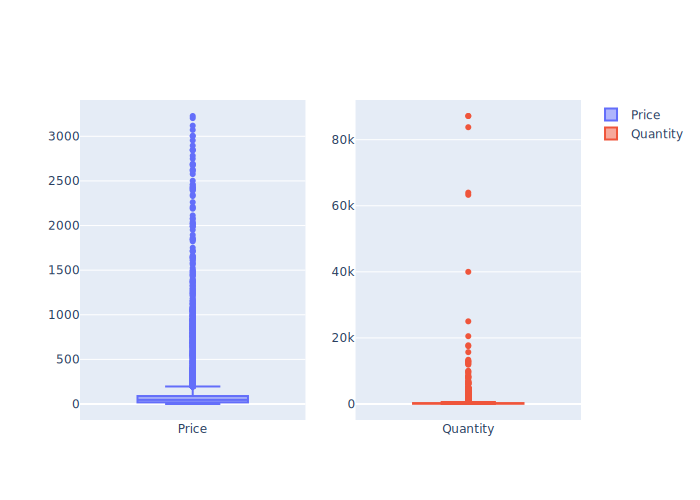

In [64]:
fig = make_subplots(rows=1, cols=2)

fig.add_box(y=invoices.Price, name='Price', row=1, col=1)

fig.add_box(y=invoices.Quantity, name='Quantity', row=1, col=2)

fig.show('svg')

The upper fence value of `Price` is 196.37, and we can still see many other points above it! The same happens with `Quantity`, but with an upper fence value of 609.

All these values above the upper fence can be considered `outliers`, but are they really? In an ideal scenario, we would ask someone from the company for additional info. Maybe their IT team or sales team could help us identify how many of these outliers are real purchases or just wrong data. Some values of `Quantity` are waaay too high (who buys 40k items all at once on an e-store?), while the top-price invoice is way too expensive. Are these real data? Are these some sort of a scam? Did these purchases really happened?

Questions, questions...

Obviously we can't answer them, so let's create 3 new datasets, doing the following:
1) Keep this dataset as it is, considering all entries to be valid;
2) Remove all extreme outliers and carry on with our analyses;
3) Remove all mild outliers and, consequently, all extreme outliers as well.

## RIGHT,
but what is the difference between extreme and mild outliers?

Mild outliers are points beyond the inner fence on either side (lower/upper sides) of the box plot.
Extreme outliers are points beyond the outer fence.

![aa](https://www.researchgate.net/profile/Melida-Gutierrez/publication/266227283/figure/fig4/AS:667861664149525@1536242037927/Schematic-representation-of-Box-Plot-method.png)

Therefore:

In [65]:
IQ = invoices.quantile(.75) - invoices.quantile(.25)

IQ_quantity = IQ['Quantity']
IQ_price = IQ['Price']

UIF_quantity = invoices.Quantity.quantile(.75) + 1.5 * IQ_quantity
UOF_quantity = invoices.Quantity.quantile(.75) + 3 * IQ_quantity

UIF_price = invoices.Price.quantile(.75) + 1.5 * IQ_price
UOF_price = invoices.Price.quantile(.75) + 3 * IQ_price

Before we divide the data in 3 different groups, as stated before, we must take note of which invoices were removed, so that we can backpropagate this info to the dataframe displaying the info of all of the items (i.e., `df`).

___

- Group 1: Keep this dataset as it is, considering all entries to be valid.

 Dataframe of invoices: `invoices`

 Dataframe of items: `df`

- Group 2: Remove all extreme outliers and carry on with our analyses.

 Dataframe of invoices: `invoices_group2`

In [66]:
# Keeping track of which invoices are going to be removed:
removed_invoices = invoices.query('(Quantity > @UOF_quantity) | (Price > @UOF_price)').index.tolist()

print(f"Total of invoices removed: {len(removed_invoices)}")

Total of invoices removed: 1328


In [67]:
invoices_group2 = invoices.query("index not in @removed_invoices")

 Dataframe of items: `df_group2`

In [68]:
# Creating the dataframe of items for this group (backpropagation):
df_group2 = df.query("Invoice not in @removed_invoices")

- Group 3: Remove all mild and extreme outliers.

 Dataframe of invoices: `invoices_group3`

In [69]:
# Keeping track of which invoices are going to be removed:
removed_invoices = invoices.query('(Quantity > @UIF_quantity) | (Price > @UIF_price)').index.tolist()

print(f"Total of invoices removed: {len(removed_invoices)}")

Total of invoices removed: 2628


In [70]:
invoices_group3 = invoices.query("index not in @removed_invoices")

 Dataframe of items: `df_group3`

In [71]:
# Creating the dataframe of items for this group (backpropagation):
df_group3 = df.query("Invoice not in @removed_invoices")

To sum it up:

Group 1:

In [72]:
print(f"Total number of rows in the imported dataset (original): {n_original_rows}\n\
Number of rows at the moment (dataframe of items for this group): {df.shape[0]}\n\
% of data removed so far: {100*(1-df.shape[0]/n_original_rows):.2f}")

Total number of rows in the imported dataset (original): 525461
Number of rows at the moment (dataframe of items for this group): 509292
% of data removed so far: 3.08


Group 2:

In [73]:
print(f"Total number of rows in the imported dataset (original): {n_original_rows}\n\
Number of rows at the moment (dataframe of items for this group): {df_group2.shape[0]}\n\
% of data removed so far: {100*(1-df_group2.shape[0]/n_original_rows):.2f}")

Total number of rows in the imported dataset (original): 525461
Number of rows at the moment (dataframe of items for this group): 374517
% of data removed so far: 28.73


Group 1:

In [74]:
print(f"Total number of rows in the imported dataset (original): {n_original_rows}\n\
Number of rows at the moment (dataframe of items for this group): {df_group3.shape[0]}\n\
% of data removed so far: {100*(1-df_group3.shape[0]/n_original_rows):.2f}")

Total number of rows in the imported dataset (original): 525461
Number of rows at the moment (dataframe of items for this group): 310403
% of data removed so far: 40.93


___

Good, now let's see those histograms again, but this time using our newly-generated groups.

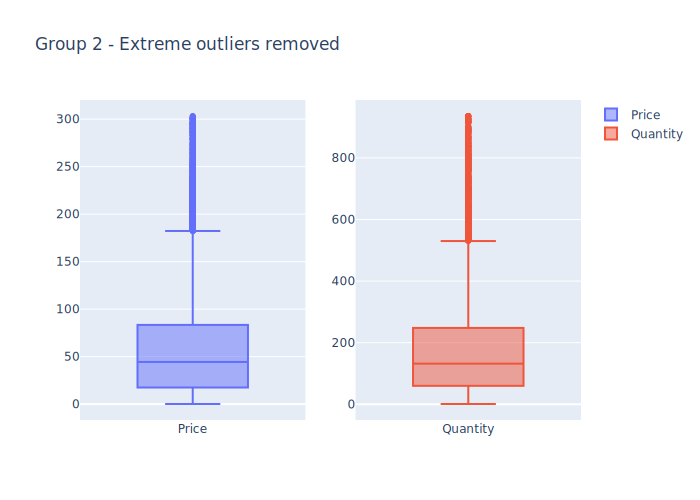

In [75]:
fig = make_subplots(rows=1, cols=2)

fig.add_box(y=invoices_group2.Price, name='Price', row=1, col=1)

fig.add_box(y=invoices_group2.Quantity, name='Quantity', row=1, col=2)

fig.update_layout(title='Group 2 - Extreme outliers removed')

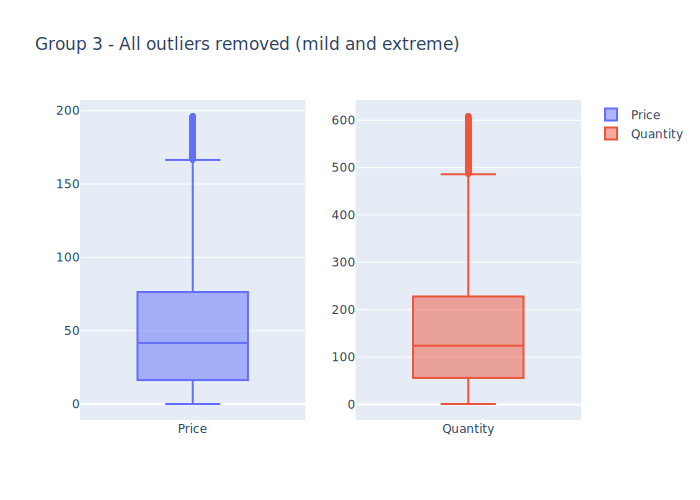

In [76]:
fig = make_subplots(rows=1, cols=2)

fig.add_box(y=invoices_group3.Price, name='Price', row=1, col=1)

fig.add_box(y=invoices_group3.Quantity, name='Quantity', row=1, col=2)

fig.update_layout(title='Group 3 - All outliers removed (mild and extreme)')

fig.show('svg')

Yay, we've made it to the end of part 1! To finish off, let's just export the dataframes of our 3 groups into .csv files, so that we can easily load them in the next part


See you there!

In [77]:
df.to_csv('data/Created in part 01/group1_items.csv')
invoices.to_csv('data/Created in part 01/group1_invoices.csv')

df_group2.to_csv('data/Created in part 01/group2_items.csv')
invoices_group2.to_csv('data/Created in part 01/group2_invoices.csv')

df_group3.to_csv('data/Created in part 01/group3_items.csv')
invoices_group3.to_csv('data/Created in part 01/group3_invoices.csv')